In [1]:
import colorsys
import cv2
import math
import numpy as np
import os
import pandas as pd
import sys
from collections import deque, Counter
from matplotlib import pyplot as plt
from pathlib import Path
from skimage import morphology
from sklearn import cluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.utils import resample

In [2]:
# https://github.com/tesseract-ocr/tesseract/releases/tag/4.1.1
# Follow https://orionfoysal.github.io/Installing-Tesseract4.0/ for installing tesseract for OCR
# https://tesseract-ocr.github.io/tessdoc/Compiling-%E2%80%93-GitInstallation.html
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'  
!tesseract -v

tesseract 4.1.1
 leptonica-1.78.0
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.4.2) : libpng 1.2.54 : libtiff 4.0.6 : zlib 1.2.8 : libwebp 0.4.4 : libopenjp2 2.1.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE


In [3]:
print(sys.version)
print(cv2.__version__)
print(np.__version__)
print(pd.__version__)

3.8.2 (default, Mar 26 2020, 15:53:00) 
[GCC 7.3.0]
4.5.0
1.19.2
1.1.3


# 1. Getting the ROI

In [4]:
# SOURCE for this cell: https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp
# Code for Merging Closeby Lines

def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]

def merge_closeby_lines(lines, min_distance_to_merge = 30, min_angle_to_merge = 30):
    # merge lines

    _lines = []
    for _line in get_lines(lines):
        _lines.append([(_line[0], _line[1]),(_line[2], _line[3])])

    # sort
    _lines_x = []
    _lines_y = []
    for line_i in _lines:
        orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
        if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
            _lines_y.append(line_i)
        else:
            _lines_x.append(line_i)

    _lines_x = sorted(_lines_x, key=lambda _line: _line[0][0])
    _lines_y = sorted(_lines_y, key=lambda _line: _line[0][1])

    merged_lines_x = merge_lines_pipeline_2(_lines_x, min_distance_to_merge = min_distance_to_merge, min_angle_to_merge = min_angle_to_merge)
    merged_lines_y = merge_lines_pipeline_2(_lines_y, min_distance_to_merge = min_distance_to_merge, min_angle_to_merge = min_angle_to_merge)

    merged_lines_all = []
    merged_lines_all.extend(merged_lines_x)
    merged_lines_all.extend(merged_lines_y)
#     print("process groups lines", len(_lines), len(merged_lines_all))

    return merged_lines_all

def merge_lines_pipeline_2(lines, min_distance_to_merge = 30, min_angle_to_merge = 30):
    super_lines_final = []
    super_lines = []

    for line in lines:
        create_new_group = True
        group_updated = False

        for group in super_lines:
            for line2 in group:
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))
                        group.append(line)

                        create_new_group = False
                        group_updated = True
                        break

            if group_updated:
                break

        if (create_new_group):
            new_group = []
            new_group.append(line)

            for idx, line2 in enumerate(lines):
                # check the distance between lines
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))

                        new_group.append(line2)

                        # remove line from lines list
                        #lines[idx] = False
            # append new group
            super_lines.append(new_group)


    for group in super_lines:
        super_lines_final.append(merge_lines_segments1(group))

    return super_lines_final

def merge_lines_segments1(lines, use_log=False):
    if(len(lines) == 1):
        return lines[0]

    line_i = lines[0]

    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))

    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])

    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):

        #sort by y
        points = sorted(points, key=lambda point: point[1])

        if use_log:
            print("use y")
    else:

        #sort by x
        points = sorted(points, key=lambda point: point[0])

        if use_log:
            print("use x")

    return [points[0], points[len(points)-1]]

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
# https://stackoverflow.com/questions/32702075/what-would-be-the-fastest-way-to-find-the-maximum-of-all-possible-distances-betw
def lines_close(line1, line2):
    dist1 = math.hypot(line1[0][0] - line2[0][0], line1[0][0] - line2[0][1])
    dist2 = math.hypot(line1[0][2] - line2[0][0], line1[0][3] - line2[0][1])
    dist3 = math.hypot(line1[0][0] - line2[0][2], line1[0][0] - line2[0][3])
    dist4 = math.hypot(line1[0][2] - line2[0][2], line1[0][3] - line2[0][3])

    if (min(dist1,dist2,dist3,dist4) < 100):
        return True
    else:
        return False

def lineMagnitude (x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2)+ math.pow((y2 - y1), 2))
    return lineMagnitude

#Calc minimum distance from a point and a line segment (i.e. consecutive vertices in a polyline).
# https://nodedangles.wordpress.com/2010/05/16/measuring-distance-from-a-point-to-a-line-segment/
# http://paulbourke.net/geometry/pointlineplane/
def DistancePointLine(px, py, x1, y1, x2, y2):
    #http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/source.vba
    LineMag = lineMagnitude(x1, y1, x2, y2)

    if LineMag < 0.00000001:
        DistancePointLine = 9999
        return DistancePointLine

    u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
    u = u1 / (LineMag * LineMag)

    if (u < 0.00001) or (u > 1):
        #// closest point does not fall within the line segment, take the shorter distance
        #// to an endpoint
        ix = lineMagnitude(px, py, x1, y1)
        iy = lineMagnitude(px, py, x2, y2)
        if ix > iy:
            DistancePointLine = iy
        else:
            DistancePointLine = ix
    else:
        # Intersecting point is on the line, use the formula
        ix = x1 + u * (x2 - x1)
        iy = y1 + u * (y2 - y1)
        DistancePointLine = lineMagnitude(px, py, ix, iy)

    return DistancePointLine

def get_distance(line1, line2):
    dist1 = DistancePointLine(line1[0][0], line1[0][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist2 = DistancePointLine(line1[1][0], line1[1][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist3 = DistancePointLine(line2[0][0], line2[0][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    dist4 = DistancePointLine(line2[1][0], line2[1][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])


    return min(dist1,dist2,dist3,dist4)

In [5]:
def get_aligned_axes_from_lines(lines, h_image, w_image, thresh=0.6, epsilon=5):
    # expects plots to be around center of image
    # assumes x_axis is below plot and y_axis is to the left of plot
    # lines = [n_lines, 2, 2]
    # x_axis_connected = (left_point, right_point)
    # y_axis_connected = (top_point, bottom_point)
    
    # see if you can increase thresh value
    horizontal_lines = []
    vertical_lines = []
    for line in lines:
        if (abs(line[0][1] - line[1][1]) <= epsilon): # y coordinates similar
            horizontal_lines.append(line)
        elif (abs(line[0][0] - line[1][0]) <= epsilon): # x coordinates similar
            vertical_lines.append(line)
            
    h_center = h_image//2
    w_center = w_image//2
    x_axis_candidates = []
    y_axis_candidates = []
    max_x_length = max_y_length = -1
    
    for line in horizontal_lines:
        y_line = min(line[0][1], line[1][1])
        x_start = min(line[0][0], line[1][0])
        x_end = max(line[0][0], line[1][0])
        if (y_line >= h_center): # line is below center
            x_axis_candidates.append(((x_start, y_line), (x_end, y_line)))
            max_x_length = max(max_x_length, x_end-x_start)
    x_axis_candidates.sort(key = lambda line: (line[0][1], line[0][0]))
    for line in x_axis_candidates:
        if line[1][0]-line[0][0] >= max_x_length*thresh:
            x_axis = line
            break
            
    for line in vertical_lines:
        x_line = max(line[0][0], line[1][0])
        y_start = min(line[0][1], line[1][1])
        y_end = max(line[0][1], line[1][1])
        if (x_line <= w_center): # line is to left of center
            y_axis_candidates.append(((x_line, y_start), (x_line, y_end)))
            max_y_length = max(max_y_length, y_end-y_start)
    y_axis_candidates.sort(key = lambda line: (-line[0][0], line[0][1]))
    for line in y_axis_candidates:
        if line[1][1]-line[0][1] >= max_y_length*thresh:
            y_axis = line
            break
            
    # intersection
    y_axis_connected = ((y_axis[0][0], y_axis[0][1]), (y_axis[1][0], x_axis[0][1]))
    x_axis_connected = ((y_axis[1][0], x_axis[0][1]), (x_axis[1][0], x_axis[1][1]))
    return x_axis_connected, y_axis_connected

In [6]:
def get_roi_bounds(img, x_axis, y_axis, gap = 3):
    # returns filtered_crop, (r1, r2), (c1, c2)
    # roi is img[r1:r2+1, c1:c2+1]

    h, w, c = img.shape
    r1_0 = y_axis[0][1]; r1_s = max(0, r1_0-gap); r1_e = min(h-1, r1_0+gap)
    r2_0 = y_axis[1][1]; r2_s = max(0, r2_0-gap); r2_e = min(h-1, r2_0+gap)
    c1_0 = x_axis[0][0]; c1_s = max(0, c1_0-gap); c1_e = min(w-1, c1_0+gap)
    c2_0 = x_axis[1][0]; c2_s = max(0, c2_0-gap); c2_e = min(w-1, c2_0+gap)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 0, 0], np.uint8)
    upper_bound = np.array([179, 255, 200], np.uint8) # [179, 255, 255]
    black_mask = (cv2.inRange(hsv, lower_bound, upper_bound) > 0)
    
    # filters out black axes from image. Replaces them with white background
    img_copy = img.copy()
    for (r_start, r_end) in [(r1_s, r1_e), (r2_s, r2_e)]:
        img_section = img_copy[r_start:r_end+1,:]
        mask_section = black_mask[r_start:r_end+1,:]
        img_section[mask_section] = 255
    for (c_start, c_end) in [(c1_s, c1_e), (c2_s, c2_e)]:
        img_section = img_copy[:,c_start:c_end+1]
        mask_section = black_mask[:,c_start:c_end+1]
        img_section[mask_section] = 255
        
    crop_1 = img_copy[r1_s:r2_e+1, c1_s:c2_e+1]
#     cv2.imshow('crop_1', crop_1) 
    
    return crop_1, (r1_s, r2_e), (c1_s, c2_e)

In [7]:
def get_cropped_plot(img):
    # returns scaled image, coordinate bounds, and axes
    # expects the plot to be somewhere in the centre of image
    # identify long horizontal lines in graph (if multiple, choose the ones immediately below centre of image)
    # identify long vertical lines in graph (if multiple, choose the ones immediately left to centre of image)
    # assume that axes are going to be dark

    h, w, c = img.shape

    # use hsv to threshold black axes
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 0, 0], np.uint8)
    upper_bound = np.array([179, 255, 100], np.uint8) # [179, 255, 255]
    mask_hsv = cv2.inRange(hsv, lower_bound, upper_bound)    
#     cv2.imshow('mask_hsv', mask_hsv)

#     Canny edge detection causes too many spurious edges. Hence we don't use it here.
#     edges = cv2.Canny(mask_hsv, 50, 150, apertureSize = 7)

    # Filtering using width and height of components for axes detection    
    # Removing short components
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask_hsv, connectivity=8)
    nb_components = nb_components - 1 # Removing background from component list
    widths = stats[1:, cv2.CC_STAT_WIDTH] # Removing background from component list
    heights = stats[1:, cv2.CC_STAT_HEIGHT] # Removing background from component list
    min_height = math.ceil(h/15)  
    min_width = math.ceil(w/15)  
    filtered_mask_hsv = np.zeros_like(mask_hsv)
    for i in range(0, nb_components):
        if widths[i] >= min_width or heights[i] >= min_height: #retain only tall or wide components
            filtered_mask_hsv[output == i + 1] = 255
#     cv2.imshow('filtered_mask_hsv', filtered_mask_hsv)

    # Line Segment Detection using HoughLinesP
    # alternatives using cv2.createLineSegmentDetector and cv2.ximgproc.createFastLineDetector were not that effective
    # minLineLength = 200
    # maxLineGap = 50
    # threshold = 100
    minLineLength = math.ceil((h+w)/10)
    maxLineGap = math.ceil((h+w)/20)
    threshold = 100
    lines = cv2.HoughLinesP(filtered_mask_hsv,
                            rho=1,
                            theta=np.pi/180,
                            threshold=threshold,
                            minLineLength=minLineLength,
                            maxLineGap=maxLineGap)
    print('lines before merging\n', lines)
#     hough_lines_img = np.zeros_like(filtered_mask_hsv)
#     for line in lines:
#         x1,y1,x2,y2 = line[0]
#         cv2.line(hough_lines_img,(x1,y1),(x2,y2),255,2)
#     cv2.imshow('hough_lines_img:   ' + str(len(lines)) + ' initial edges detected', hough_lines_img) 
    
    # Merging close by detected lines
    # merged_lines = merge_closeby_lines(lines, min_distance_to_merge = 30, min_angle_to_merge = 30)
    merged_lines = merge_closeby_lines(lines, min_distance_to_merge = math.ceil((h+w)/60), min_angle_to_merge = 15)
    print('lines after merging\n', merged_lines)
#     hough_merged_lines_img = np.zeros_like(filtered_mask_hsv)
#     for line in merged_lines:
#         cv2.line(hough_merged_lines_img, (line[0][0], line[0][1]), (line[1][0],line[1][1]), 255, 2)
#     cv2.imshow('hough_merged_lines_img:   ' + str(len(merged_lines)) + ' final edges detected', hough_merged_lines_img) 

    x_axis, y_axis = get_aligned_axes_from_lines(merged_lines, h, w, thresh=0.6, epsilon=5)
    axis_img = np.zeros_like(filtered_mask_hsv)
    for line in [x_axis, y_axis]:
        cv2.line(axis_img, (line[0][0], line[0][1]), (line[1][0],line[1][1]), 255, 2)
    cv2.imshow('axis_img', axis_img) 
    
    cropped_plot, row_range, col_range = get_roi_bounds(img, x_axis, y_axis, gap=3)
#     cv2.imshow('cropped_plot', cropped_plot) 
    return cropped_plot, row_range, col_range, x_axis, y_axis


# 2. Segmenting ROI into different coloured plots

In [8]:
def get_best_k(data, k_max=12, n_samples=1000):
    # input data expected to be normalized to 0-1
    n_samples = min(n_samples, len(data))
    print('n_samples =', n_samples)
    sse = {}
    sil_coeffs = {}
    for k in range(1, k_max+1):
        kmeans_cluster = cluster.KMeans(n_clusters=k).fit(data)
        sse[k] = kmeans_cluster.inertia_  # Inertia: Sum of distances of samples to their closest cluster center
        label = kmeans_cluster.labels_
        if k>1:
            # this takes too long because O(n^2)
#             sil_coeffs[k] = silhouette_score(data, label, metric='euclidean')
#             sil_coeffs[k] = calinski_harabasz_score(data, label)
            sample_data, sample_label = resample(data, label, replace=False, n_samples=n_samples)
            sil_coeffs[k] = silhouette_score(sample_data, sample_label, metric='euclidean')
            print("For k={}, The Silhouette Coefficient is {}".format(k, sil_coeffs[k]))
    fig = plt.figure(figsize=(14,7))
    fig.add_subplot(121)
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    fig.add_subplot(122)
    plt.plot(list(sil_coeffs.keys()), list(sil_coeffs.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    return max(sil_coeffs, key=sil_coeffs.get)

In [9]:
def encode_hex(center):
    b=int(center[0]*255)
    g=int(center[1]*255)
    r=int(center[2]*255)
    hex = '#'+str(bytearray([r,g,b]).hex())
    return hex

def visualize_bgr_cluster_centers(cluster_centers):
    fig = plt.figure()
    for i, center in enumerate(cluster_centers):
        plt.bar(i, 5, color=encode_hex(center))
    # show and save plot
    plt.show()
    plt.close(fig)

In [10]:
def segment_plots_by_color(img, num_clusters=-1, area_thresh=0.3):
    # returns segmentation mask and number of plot labels found

    # remove white background to get foreground mask
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img_gray, 220, 255, cv2.THRESH_BINARY_INV)
        
    # the union of all plots is expected to be the largest connected component in the non-white foreground of the roi.
    # this filter is expected to take away legend and other stuff
    # unfortunatelty, this will also remove any dashed lines from the graph
    # we do this before the process where we remove small components, so that the plots are all still connected as in the original
    label_union_mask = mask
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(label_union_mask, connectivity=8)
    # cv2.CC_STAT_AREA, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT, cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP        
    # component 0 is background, and hence skipped
    big_comp_ind = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    big_comp_mask = (output == big_comp_ind)
    mask = big_comp_mask.astype(np.uint8)*255
#     cv2.imshow('foreground_mask', mask)

    # normalize pixel values to range 0 to 1
    img_norm = img / 255
    h, w, c = img_norm.shape
    mask_reshaped = mask.reshape(h*w)
    img_norm_reshaped = img_norm.reshape(h*w, c)
    clustering_data = img_norm_reshaped[(mask_reshaped>0),:]
    # print(clustering_data.shape)

    # identify ideal number of kmeans clusters
    if num_clusters == -1:
        print('identifying best num_clusters >= 2')
        num_clusters = get_best_k(clustering_data, k_max=12, n_samples=2000)
    print('using num_clusters =', num_clusters)
    
    img2 = img.reshape(h*w, c) / 255
    kmeans_cluster = cluster.KMeans(n_clusters=num_clusters)
    kmeans_cluster.fit(clustering_data) # using white background removed clustering_data
    # kmeans_cluster.fit(img2) # using whole image data
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_

    inertia = kmeans_cluster.inertia_ # Sum of squared distances of samples to their closest cluster center.

    visualize_bgr_cluster_centers(cluster_centers)
    print('cluster_centers =', cluster_centers)
#     print('cluster_labels =', cluster_labels)

    cluster_labels = kmeans_cluster.predict(img2)
    cluster_labels[(mask_reshaped==0)] = num_clusters # background gets last label
    cluster_labels = cluster_labels.reshape(h, w)
    
#     label_areas = []
#     for i in range(num_clusters+1):
#         label_areas.append((cluster_labels==i).sum())
#     print('Post step 1 label_areas =', label_areas)

    # removing small objects
    # This is done because there might be tiny blobs sticking to the union of plots.
    # These might be of similar color to actual labels. These free hanging flecks disrupt plot calculation.
    # These might be also be flecks of a random colour, that accumulate in size to pass the 30% threshold.
    label_areas = []
    processed_cluster_labels = cluster_labels.copy()
    processed_cluster_labels[:,:] = num_clusters
    for i in range(num_clusters): # don't iterate background colour
        label_mask = (cluster_labels==i)
        min_size = math.ceil((h+w)/50)
        processed_mask = morphology.remove_small_objects(label_mask, min_size=min_size, connectivity=1)
#         processed_mask = morphology.remove_small_objects(label_mask, min_size=10, connectivity=1)
        # instead you could try using morphological opening or closing
        processed_cluster_labels[processed_mask] = i
        label_areas.append(processed_mask.sum())
    label_areas.append((processed_cluster_labels==num_clusters).sum())
    print('Post step 2 label_areas =', label_areas)

    # threshold away labels with area less than 30% of largest label area
    threshold_area = int(max(label_areas[:-1])*area_thresh)
    print('threshold_area =', threshold_area)

    cur_label = 0
    new_label_areas = []
    for i in range(num_clusters): # don't iterate background colour
        if label_areas[i] < threshold_area:
            processed_cluster_labels[processed_cluster_labels == i] = num_clusters
        else:
            processed_cluster_labels[processed_cluster_labels == i] = cur_label
            new_label_areas.append(label_areas[i])
            cur_label += 1
    processed_cluster_labels[processed_cluster_labels == num_clusters] = cur_label
    new_label_areas.append((processed_cluster_labels==cur_label).sum())
    label_areas = new_label_areas
    num_clusters = cur_label

    print('final label_areas =', label_areas)

#     for i in range(num_clusters+1):
#         label_mask = img.copy()
#         label_mask[processed_cluster_labels!=i] = 0
#         cv2.imshow('label_mask = {}'.format(i), label_mask)
#         cv2.imshow('processed_mask = {}'.format(i), (processed_cluster_labels==i).astype(np.uint8)*255)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
    return processed_cluster_labels, num_clusters

# 3. Extrapolating coordinates from plots

In [11]:
def get_top_label_and_start(cluster_labels, n_labels):
    # plots always begin in left and move towards right
    # returns top_label, coordinates of starting point, and whether flipped (i.e, increasing instead of decreasing)
    start_c = 100000
    start_r_top = 100000
    start_r_bottom = -1
    top_label_top = 0
    top_label_bottom = 0
    
    h, w = cluster_labels.shape
    
    for i in range(n_labels): # don't iterate background colour
        label_mask = (cluster_labels == i).astype(np.uint8)
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(label_mask, connectivity=8)
        # cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT, cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP        
        big_comp_ind = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1 # component 0 is background, and hence skipped
                
        big_comp_left = stats[big_comp_ind, cv2.CC_STAT_LEFT]
        big_comp_left_top = 100000
        big_comp_left_bottom = -1
        for k in range(h):
            if output[k, big_comp_left] == big_comp_ind:
                big_comp_left_top = min(big_comp_left_top, k)
                big_comp_left_bottom = max(big_comp_left_bottom, k)
                
        if big_comp_left < start_c:
            start_c = big_comp_left
            start_r_top = big_comp_left_top
            start_r_bottom = big_comp_left_bottom
            top_label_top = i
            top_label_bottom = i
    
        elif big_comp_left == start_c:
            if big_comp_left_top < start_r_top:
                start_r_top = big_comp_left_top
                top_label_top = i
            if big_comp_left_bottom > start_r_bottom:
                start_r_bottom = big_comp_left_bottom
                top_label_bottom = i
    
    # returns top_label, coordinates of starting point, and whether flipped
    if start_r_top < h/2:
        # graph starts at the top and keeps decreasing
        return top_label_top, (start_r_top, start_c), False
    else:
        # graph starts at the bottom and keeps increasing
        return top_label_bottom, (start_r_bottom, start_c), True        


In [12]:
def get_min_max_values(cluster_labels, n_labels):
    # n_labels doesn't include the background
    nr, nc = cluster_labels.shape
    min_values = np.full([n_labels+1, nc], np.iinfo(np.int32).max, dtype=np.int32)
    max_values = np.full([n_labels+1, nc], np.iinfo(np.int32).min, dtype=np.int32)
    
    for i in range(nr):
        for j in range(nc):
            l = cluster_labels[i,j]
            min_values[l,j] = min(min_values[l,j], i)
            max_values[l,j] = max(max_values[l,j], i)
    return min_values, max_values

In [13]:
def find_connection(grid, start, end, min_values, max_values):
    # grid = [n_rows x n_cols] bool
    # min_values = [n_cols] int (for that colour)
    # max_values = [n_cols] int (for that colour)
    # start and end = (int, int)
    # assumption sr <= er and sc+1 < ec (graph goes from top left to bottom right)
    
#     print('\nin find_connection', 'start =', start, 'end =', end)
    sr, sc = start # row, col
    er, ec = end
    
    if sr >= er:
        np.minimum(min_values[sc:ec+1], er, out=min_values[sc:ec+1])
        np.maximum(max_values[sc:ec+1], sr, out=max_values[sc:ec+1])
        return True
    
    visited = np.zeros_like(grid, dtype=np.uint8)
    q = deque()
    q.append((sr, sc))
    while q:
        r,c = q.popleft()
#         if r==er and c==ec:
#             break
            
        next_r, next_c = r+1, c
        mode = 1
        if (next_r <= er) and (next_c <= ec) and (visited[next_r, next_c] == 0):
            if next_r==er and next_c==ec:
                visited[next_r, next_c] = mode
                break
            elif (grid[next_r, next_c] == True):
                visited[next_r, next_c] = mode
                q.append((next_r, next_c))
        
        next_r, next_c = r, c+1
        mode = 2
        if (next_r <= er) and (next_c <= ec) and (visited[next_r, next_c] == 0):
            if next_r==er and next_c==ec:
                visited[next_r, next_c] = mode
                break
            elif (grid[next_r, next_c] == True):
                visited[next_r, next_c] = mode
                q.append((next_r, next_c))
            
    if visited[er, ec] == 0:
        return False
    else:
        r,c = er,ec
        min_values[c] = min(min_values[c], r)
        max_values[c] = max(max_values[c], r)
        while not (r==sr and c==sc):
            if visited[r,c] == 1:
                r -= 1
            elif visited[r,c] == 2:
                c -= 1
            else:
                raise Exception('something wrong in find_connection')
            
            min_values[c] = min(min_values[c], r)
            max_values[c] = max(max_values[c], r)
                
        return True


In [14]:
def get_next_pos(cur_c, label_max_values):
    nc = len(label_max_values)
    for c in range(cur_c+1, nc):
        if label_max_values[c] != np.iinfo(np.int32).min:
            return c
    return None

In [15]:
def check_label_completeness(label_max_values, start_c, tolerance=2):
    c = start_c
    while True:
        next_c = get_next_pos(c, label_max_values)
        if next_c is None:
            return True
        elif next_c - c <= tolerance:
            c = next_c
        else:
            return False

In [16]:
def add_next_label(cum_fg, start_c, label_min_values, label_max_values):
    unexplained_length = 0
    c = start_c
    while True:
        next_c = get_next_pos(c, label_max_values)
        if next_c is None:
            return unexplained_length
        elif next_c - c <= 1:
            c = next_c
        else:
            connected = find_connection(grid=cum_fg,
                                        start=(label_max_values[c], c),
                                        end=(label_min_values[next_c], next_c),
                                        min_values=label_min_values,
                                        max_values=label_max_values)
            if not connected:
                unexplained_length += (max(0, next_c-c-1) + max(0, label_min_values[next_c]-label_max_values[c]-1))
            c = next_c

In [17]:
def filter_and_interpolate(max_values, start_c):
    # max_values here does not include background
    # linear interpolation in sections where you are unable to connect eventually
    
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    
    plot_data = max_values.astype(np.float32)
    plot_data[plot_data == np.iinfo(np.int32).min] = np.nan
    
    for sequence in plot_data:
        end_c = start_c
        cur = sequence[start_c]
        for j in range(start_c, len(sequence)):
            if not np.isnan(sequence[j]):
                sequence[j] = max(sequence[j], cur)
                cur = sequence[j]
                end_c = j

        roi = sequence[start_c : end_c+1]
        nans, x = nan_helper(roi)
        roi[nans]= np.interp(x(nans), x(~nans), roi[~nans]) # should change in-place in plot_data

    return plot_data

In [18]:
def compute_plots(cluster_labels, n_labels):
    # assumes top left corner to be the beginning point for all plots, with pixel value as top label
    # assumes monotonically decreasing graph, with top label at (0,0)
    # the output is max_values
    # n_labels doesn't include the background
    min_values, max_values = get_min_max_values(cluster_labels, n_labels)
    
    start_r, start_c = 0, 0
    top_label = cluster_labels[start_r, start_c]
    
    cum_fg = (cluster_labels == top_label)
    remaining_labels = list(range(n_labels))
    remaining_labels.remove(top_label)
        
    for l in remaining_labels:
        min_values[l, start_c] = start_r # should be same for all plots
        max_values[l, start_c] = max(max_values[l, start_c], start_r)
    
    while remaining_labels:
        se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        dilated_cum_fg = cv2.morphologyEx(cum_fg.astype(np.uint8), cv2.MORPH_DILATE, se1).astype(np.bool)          
            
        unexplained_lengths = {}
        next_added = -1
        for l in remaining_labels:
            print('trying to combine label', l)
            label_unexplained_length = add_next_label(dilated_cum_fg, start_c, min_values[l], max_values[l])
            unexplained_lengths[l] = label_unexplained_length
            if label_unexplained_length == 0:
                next_added = l
                break
                
        if next_added == -1:
            next_added = min(unexplained_lengths, key=unexplained_lengths.get) 
        
        print('next_added =', next_added, 'with unexplained_length =', unexplained_lengths[next_added])
            
        cum_fg |= (cluster_labels == next_added)
        remaining_labels.remove(next_added)
    
    plot_data = filter_and_interpolate(max_values[:-1], start_c) # exclude background
    return plot_data

In [19]:
def visualize_plot_coordinates(plot_coordinates, h, w):
    n_labels = len(plot_coordinates)
    graph = np.zeros((h, n_labels*w), dtype=np.uint8)
    
    for i in range(n_labels):
        sequence = plot_coordinates[i]
        for j in range(w):
            if not np.isnan(sequence[j]):
                graph = cv2.circle(graph, (i*w+j, int(sequence[j])), radius=1, color=(255), thickness=-1)
#                 graph[int(sequence[j]), i*w+j] = 255
    return graph
    

# 4. Identifying range of X axis

In [20]:
def get_xrange_roi_mask(img, x_axis):
#     print('reached get_xrange_roi_mask')
    h,w,c = img.shape
    
    (x1,y), (x2,y) = x_axis
    axis_len = x2-x1+1
    gap = 15
    l = max(0, x1 - gap)
    r = min(w-1, x2 + gap)
    
    # all area below the x axis
    img = img[y:,l:r+1]
        
    # remove white background to get foreground mask
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)
#     cv2.imshow('mask', mask)
    
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    # cv2.CC_STAT_AREA, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT, cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP        
    thresh_ratio = 0.1
    max_width_thresh = math.ceil(axis_len * thresh_ratio)
    filtered_mask = np.zeros_like(mask)
    for i in range(1, nb_components): # component 0 is background, and hence skipped
        if stats[i, cv2.CC_STAT_WIDTH] <= max_width_thresh:
            filtered_mask[output == i] = 255
#     cv2.imshow('filtered_mask', filtered_mask)
        
    mask = filtered_mask
    bool_mask = (mask>0)
    
    h, w = mask.shape
    
    # cropping the xlabels alone 
    gap = 2 
#     len_thresh = 20
    len_thresh = 16
    
    i = 0
    while i < h and bool_mask[i].sum() <= len_thresh:
        i += 1
    tr = max(0, i-gap)
    
    while i < h and bool_mask[i].sum() >= len_thresh:
        i += 1
    br = min(h, i+gap)
   
    cropped_mask = filtered_mask[tr:br]    
    return cropped_mask


In [21]:
def get_xrange(img, x_axis):
    # assumes coordinates always begin at 0 on the left (origin)
    # returns xrange if identifiable with confidence. Else return 1.0 
        
    # try using https://github.com/MichalBusta/DeepTextSpotter instead of tesseract
    # try making thresh a fraction of image size
    try:
        cropped_mask = get_xrange_roi_mask(img, x_axis)
                
        h,w = cropped_mask.shape
        min_height = 30
        if h < min_height:
            ratio = min_height/h
            h = int(ratio*h)
            w = int(ratio*w)
            cropped_mask = cv2.resize(cropped_mask, (w, h), 0, 0, interpolation = cv2.INTER_LINEAR)
            ret, cropped_mask = cv2.threshold(cropped_mask, 150, 255, cv2.THRESH_BINARY)
#         cv2.imshow('cropped_mask', cropped_mask)
        
        # psm mode 7 is for a single line
        # legacy mode 0 seems to work best (rather than mode 1 or 2)
        # floating point and negative numbers as well
        text = pytesseract.image_to_string(cropped_mask, lang='eng',config='--oem 0 --psm 7 -c tessedit_char_whitelist=0123456789.-') 
        print('text with decimal\n', text)
        # only natural numbers
#         text = pytesseract.image_to_string(cropped_mask, lang='eng',config='--oem 0 --psm 7 -c tessedit_char_whitelist=0123456789') 
#         print('text without decimal\n', text)
    
        xlabels = np.array([float(x) for x in text.split()])
        n = len(xlabels)
        differences = xlabels[1:] - xlabels[:-1]
        
        difference_counts = Counter(differences)
        most_common_diff, count = difference_counts.most_common(1)[0]
        print('most_common_diff =', most_common_diff, 'count =', count)

        if count >= math.ceil(n/2.5):
            # assumes coordinates are always begin at 0 on the left (origin)
            xrange = 1.0*most_common_diff*(n-1)
        else:
            xrange = 1.0
        print('xrange =', xrange)
        
        cv2.imshow('text="'+text+'"  :  xrange = '+str(xrange), cropped_mask)
        
        return xrange
    except:
        return 1.0
    

# Orchestration

In [22]:
def generate_excel_sheets(filename, plot_coordinates, xrange=1.0):
    # All files stored in a new directory
    # put a separate excel file for each plot
    # also put one combined excel file for ease of plotting

    w = len(plot_coordinates[0])
    
    directory = Path(filename).stem + '_outputs'
    os.makedirs(directory, exist_ok=True)
    
    overall_dataset = pd.DataFrame()
    overall_dataset['X-axis-values'] = (np.arange(w)/(w-1))*xrange
    
    for i, sequence in enumerate(plot_coordinates):
        overall_dataset['plot_' + str(i+1)] = sequence
        x_vals = np.argwhere(~np.isnan(sequence)).flatten() # values in [0,w-1]
        x_vals = (x_vals/(w-1))*xrange
        y_vals = sequence[~np.isnan(sequence)] # values in [0,1]
        dataset = pd.DataFrame()
        dataset['X-axis-values'] = x_vals
        dataset['Y-axis-values'] = y_vals
        filename = os.path.join(directory, 'plot_' + str(i+1) + '.xlsx') 
        dataset.to_excel(filename, index=False)
        
    filename = os.path.join(directory, 'plot_all.xlsx') 
    overall_dataset.to_excel(filename, index=False)

In [23]:
def process_image(filename):
    print(filename)
    img = cv2.imread(filename)
    cv2.imshow('img', img)
    
    cropped_plot, row_range, col_range, x_axis, y_axis = get_cropped_plot(img)
#     cv2.imshow('cropped_plot', cropped_plot)    
    xrange = get_xrange(img, x_axis)
    
    # Denoising before clustering - bilateral filter seems to work best and helps a lot (as edges are important)
    denoised_cropped_plot = cv2.bilateralFilter(cropped_plot, d=9, sigmaColor=75, sigmaSpace=75)

    cluster_labels, num_clusters = segment_plots_by_color(denoised_cropped_plot, num_clusters=-1, area_thresh=0.3)
    
    h, w, c = cropped_plot.shape
    label_masks = np.tile(cropped_plot, (1,num_clusters+1,1))
    for i in range(num_clusters+1):
        single_label_mask = label_masks[:,i*w:(i+1)*w]
        single_label_mask[cluster_labels!=i] = 0
#     cv2.imshow('label_masks', label_masks)

    top_label, (start_r, start_c), flipped = get_top_label_and_start(cluster_labels, num_clusters)
    plot_start = denoised_cropped_plot.copy()
    plot_start[start_r,:,:] = 255
    plot_start[start_r,:,0] = 0
    plot_start[:,start_c,:] = 255
    plot_start[:,start_c,0] = 0    
    cv2.imshow('plot_start:  flipped = ' + str(flipped), plot_start)
    
    
    # crop image and flip it if required
    # start_r row and start_c column have to be included 
    if not flipped:
        # graph starts at the top and keeps decreasing. This is the format expected by compute_plots
        cluster_labels_final = cluster_labels[start_r:, start_c:]
    else:
        # graph starts at the top and keeps increasing.
        cluster_labels_final = cluster_labels[:start_r+1, start_c:]
        cluster_labels_final = cv2.flip(cluster_labels_final, 0) # flip upside down
#     cv2.imshow('top_label:  flipped = ' + str(flipped), (cluster_labels_final==cluster_labels_final[0,0]).astype(np.uint8)*255)
    
    
    final_h, final_w = cluster_labels_final.shape
    # compute_plots assumes monotonically decreasing graph, with top label at (0,0)
    plot_coordinates = compute_plots(cluster_labels_final, num_clusters)
    if flipped:
        plot_coordinates = (final_h-1) - plot_coordinates

    graph = visualize_plot_coordinates(plot_coordinates, final_h, final_w)
#     cv2.imshow('extrapolated graph', graph)
    
    # we do it this way because row index begins at 0 at the top and keeps increasing as we go down
    plot_coordinates_to_save = ((final_h-1) - plot_coordinates)/(final_h-1) # so that values are in [0,1]
    generate_excel_sheets(filename, plot_coordinates_to_save, xrange=xrange)

#####################################################################################################################
    # visualizing correctness of coordinate extrapolation
    if not flipped:
        cropped_plot_visualize = cropped_plot[start_r:, start_c:]
        cluster_labels_final_visualize = cluster_labels_final
    else:
        cropped_plot_visualize = cropped_plot[:start_r+1, start_c:]
        cluster_labels_final_visualize = cv2.flip(cluster_labels_final, 0)
    
    final_h, final_w, c = cropped_plot_visualize.shape
    coordinates_visualize = np.tile(cropped_plot_visualize, (1,num_clusters,1))
    coordinates_visualize_2 = coordinates_visualize.copy()
    for i in range(num_clusters):
        single_label_mask = coordinates_visualize[:,i*final_w:(i+1)*final_w]
        single_label_mask[cluster_labels_final_visualize!=i] = 0
    coordinates_visualize[graph != 0] = [0,255,255] # yellow
    cv2.imshow('coordinates_visualize', coordinates_visualize)
    coordinates_visualize_2[graph != 0] = [0,255,255] # yellow
    cv2.imshow('coordinates_visualize_2', coordinates_visualize_2)
#####################################################################################################################

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    

# Execution

orig_images/2_13.jpg
lines before merging
 [[[ 50 400 660 400]]

 [[120 461 597 461]]

 [[ 57 407  57  14]]]
lines after merging
 [[(50, 400), (660, 400)], [(120, 461), (597, 461)], [(57, 14), (57, 407)]]
text with decimal
 0 3 8 9 12 15 18 21 24

most_common_diff = 3.0 count = 6
xrange = 24.0
identifying best num_clusters >= 2
n_samples = 2000
For k=2, The Silhouette Coefficient is 0.6124944768932749
For k=3, The Silhouette Coefficient is 0.8076840805845698
For k=4, The Silhouette Coefficient is 0.9792577389888963
For k=5, The Silhouette Coefficient is 0.8244103869638925
For k=6, The Silhouette Coefficient is 0.7417892516160091
For k=7, The Silhouette Coefficient is 0.7407267012388479
For k=8, The Silhouette Coefficient is 0.6023886480144941
For k=9, The Silhouette Coefficient is 0.6095952303138736
For k=10, The Silhouette Coefficient is 0.5430627244504201
For k=11, The Silhouette Coefficient is 0.5616939110849305
For k=12, The Silhouette Coefficient is 0.5574135922465723


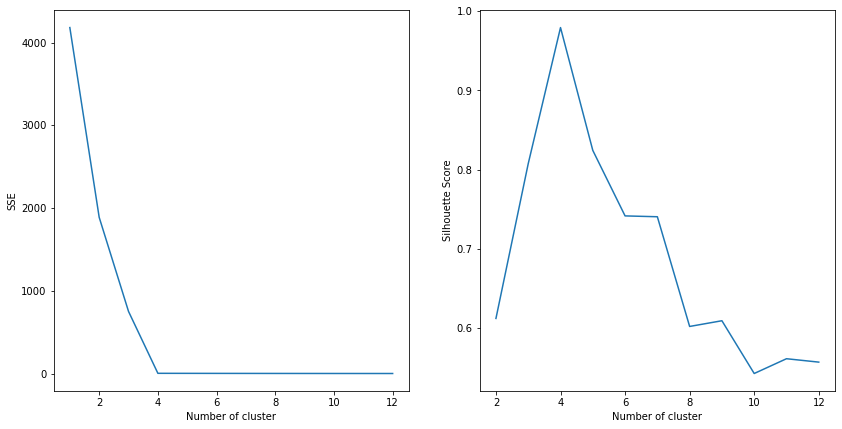

using num_clusters = 4


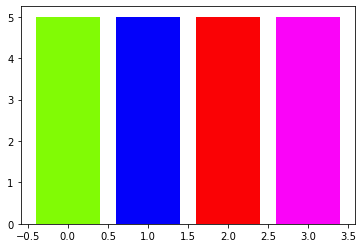

cluster_centers = [[0.02199454 0.98786296 0.50958963]
 [0.98202836 0.00592601 0.01529905]
 [0.02177175 0.01163067 0.98359933]
 [0.97373545 0.01652553 0.983719  ]]
Post step 2 label_areas = [1303, 1975, 2838, 1174, 232440]
threshold_area = 851
final label_areas = [1303, 1975, 2838, 1174, 232440]
trying to combine label 0
next_added = 0 with unexplained_length = 0
trying to combine label 1
trying to combine label 3
next_added = 3 with unexplained_length = 0
trying to combine label 1
next_added = 1 with unexplained_length = 25


In [24]:
directory = 'orig_images'
# for filename in os.listdir(directory):
#     process_image(directory + '/' + filename)
    
process_image(directory + '/' + '2_13.jpg')
# process_image(directory + '/' + '3_1.png')